In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Load images

Select folders of the same person

In [3]:
def list_files_in_folder(filepath):
    filepath = tf.strings.join([filepath, f'{os.path.sep}*.jpg'])
    
    return tf.data.Dataset.list_files(filepath, shuffle=True)

In [4]:
def get_label(filepath):
    return tf.strings.split(filepath, os.path.sep)[2]

In [5]:
def process_image(filepath):
    label = get_label(filepath)
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [128, 128])
    return img / 255.0, label

In [6]:
def create_batch(dataset, batch_size=1800, faces_per_identity=40):
    identities = batch_size // faces_per_identity
    
    identity_dataset = dataset.take(identities)
    
    first = True
    
    for identity in identity_dataset:
        if first:
            faces = identity.take(faces_per_identity)
            first = False
        else:
            faces = faces.concatenate(identity.take(faces_per_identity))
        
    faces = faces.map(process_image)
    return faces

In [7]:
batch_size = 128

dataset = tf.data.Dataset.list_files('data/train/*', shuffle=True)
dataset = dataset.map(list_files_in_folder)

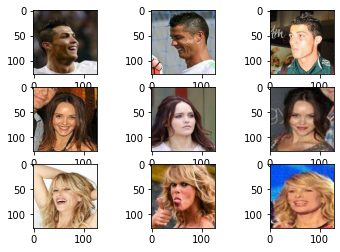

In [8]:
faces = create_batch(dataset, batch_size=9, faces_per_identity=3)

fig, axs = plt.subplots(3, 3)
i = 0

for image, label in faces:
    x = i // 3
    y = i % 3
    i += 1
    
    axs[x, y].imshow(image)

### Create model

In [3]:
base_model = tf.keras.applications.InceptionV3(include_top=False, input_shape=(128, 128, 3), weights="imagenet")
base_model.trainable = False

base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 63, 63, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [4]:
inputs = tf.keras.Input(shape=(128, 128, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(128)(x)

model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
Total params: 22,851,488
Trainable params: 1,048,704
Non-trainable params: 21,802,784
_________________________________________________________________


In [5]:
random_input = tf.random.uniform((1, 128, 128, 3))

In [ ]:
model.predict(random_input) 